In [1]:
import numpy as np
import tensorflow as tf
import math, os, sys
import matplotlib.pyplot as plt
from models.psooptimizer import Optimizer as PSOOptimizer

C:\Users\keypg\Anaconda3\envs\ml\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\keypg\Anaconda3\envs\ml\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\keypg\Anaconda3\envs\ml\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [3]:
N = 10
STEPS = 250
LOSS = 'mse'
BATCH_SIZE = 32

dataset = np.load('dataset/all_data-preprocessed.npz')
features, labels = dataset['features'].astype('float32'), dataset['labels'].astype('float32')
train_test_split_factor = .8
validation_split_factor = .2
train_x, train_y, test_x, test_y = features[:math.floor(len(features)*train_test_split_factor)], labels[:math.floor(len(labels)*train_test_split_factor)], features[math.floor(len(features)*train_test_split_factor):], labels[math.floor(len(labels)*train_test_split_factor):]
train_x, test_x = np.expand_dims(train_x, axis=-1), np.expand_dims(test_x, axis=-1) # for use with TimeDistributed
input_shape = train_x.shape
#train_y, test_y = np.expand_dims(train_y, axis=1), np.expand_dims(test_y, axis=1) # for use with TimeDistributed
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(288, 1, 7, 1) (288, 7) (72, 1, 7, 1) (72, 7)


In [4]:
def build_model(loss):
    layers = [
        tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(7, 3, padding='same', activation='relu', input_shape=input_shape[1:])),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(7, 3, padding='same', activation='relu', dilation_rate=2)),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(14, 3, padding='same', activation='relu', dilation_rate=1)),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(36, 3, padding='same', activation='relu', dilation_rate=1)),
        tf.keras.layers.Dense(70, activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(7, activation='linear')
    ]
    model = tf.keras.models.Sequential(layers=layers)
    model.compile(optimizer='adam', loss=loss)
    return model

In [5]:
def run_backpropagation(x_train, y_train, epochs=0):
    best_model = None
    best_score = float('inf')
    if epochs == 0:
        epochs = STEPS
    for i in range(N):
        model_s = build_model(LOSS)
        model_s.fit(
            x_train, y_train,
            epochs=epochs,
            batch_size=BATCH_SIZE,
            verbose=0
        )
        train_score = model_s.evaluate(x_train, y_train, batch_size=BATCH_SIZE, verbose=0)
        if train_score < best_score:
            best_model = model_s
            best_score = train_score
        return best_model

In [10]:
model_s = run_backpropagation(train_x, train_y)
b_train_score = model_s.evaluate(train_x, train_y, batch_size=BATCH_SIZE, verbose=0)
b_test_score = model_s.evaluate(test_x[:64], test_y[:64], batch_size=BATCH_SIZE, verbose=0)
print("Backprop -- train: {:.4f}  test: {:.4f}".format(b_train_score, b_test_score))

model_p = run_backpropagation(train_x, train_y) # initilize weights
pso = PSOOptimizer(model=model_p,
                  loss=LOSS,
                  n=N,
                  acceleration=1.0,
                  local_rate=.6,
                  global_rate=.4)
pso.fit(train_x, train_y, steps=STEPS, batch_size=BATCH_SIZE)
model_p = pso.get_best_model()
p_train_score = model_p.evaluate(train_x, train_y, batch_size=BATCH_SIZE, verbose=0)
p_test_score = model_p.evaluate(test_x[:64], test_y[:64], batch_size=BATCH_SIZE, verbose=0)
print("PSO -- train: {:.4f}  test: {:.4f}".format(p_train_score, p_test_score))

Backprop -- train: 1901.3984  test: 264.3827
PSO -- Initial best score 1630.0624
 [                    ] 

KeyboardInterrupt: 

In [7]:
# fit test sample into batch
max_samples_test_x = test_x.shape[0]
padd_time = 32 - (max_samples_test_x - max_samples_test_x//32*32)
test_x_fit_bs32 = test_x[64:]
for i in range(padd_time):
    test_x_fit_bs32 = np.concatenate((test_x_fit_bs32, np.expand_dims(test_x_fit_bs32[-1], axis=0)))
test_x_fit_bs32.shape
model_p.predict(test_x_fit_bs32)

array([[29.475033 , 24.168139 , -5.007413 , 25.25161  ,  4.4333324,
        69.51547  , 22.896635 ],
       [17.822302 , 23.154507 , -0.991488 ,  7.547863 , -6.6368136,
        64.989075 , 25.89886  ],
       [18.912733 , 23.916878 , -3.746746 ,  5.632106 , -4.994624 ,
        63.20171  , 25.580677 ],
       [14.657587 , 20.83323  , -0.4440918,  1.0321001, -7.4068193,
        57.919075 , 23.404179 ],
       [23.459044 , 16.462934 , -3.1353197,  1.3409752, -5.867317 ,
        55.236103 , 27.333553 ],
       [20.731781 , 21.640745 , -1.4646082, -3.1641204, -4.7446322,
        56.22202  , 22.78387  ],
       [27.669233 , 21.3664   , -2.7973428, -3.5296314, -0.6526628,
        56.018555 , 25.988548 ],
       [24.093828 , 21.784515 , -2.2506113, -2.6923053, -1.420578 ,
        56.769928 , 25.210575 ],
       [24.093828 , 21.784515 , -2.2506113, -2.6923053, -1.420578 ,
        56.769928 , 25.210575 ],
       [24.093828 , 21.784515 , -2.2506113, -2.6923053, -1.420578 ,
        56.769928 , 25.

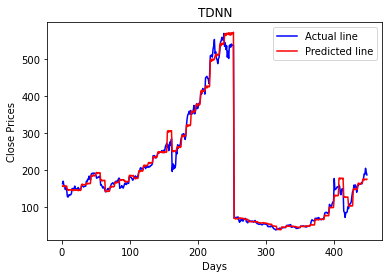

In [8]:
pred = model_s.predict(test_x[:64])
close_pred = np.reshape(pred, (-1, 1))
test_y_reshape = np.reshape(test_y[:64], (-1, 1))
days = np.arange(1, len(test_y_reshape)+1)
plt.plot(days, test_y_reshape, 'b', label='Actual line')
plt.plot(days, close_pred, 'r', label='Predicted line')
plt.title('TDNN')
plt.xlabel('Days')
plt.ylabel('Close Prices')
plt.legend()
plt.show()

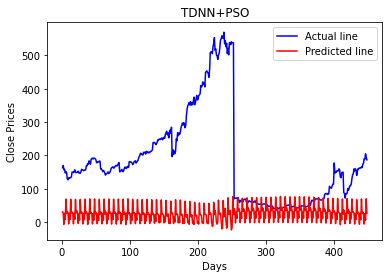

In [9]:
pred = model_p.predict(test_x[:64])
close_pred = np.reshape(pred, (-1, 1))
test_y_reshape = np.reshape(test_y[:64], (-1, 1))
days = np.arange(1, len(test_y_reshape)+1)
plt.plot(days, test_y_reshape, 'b', label='Actual line')
plt.plot(days, close_pred, 'r', label='Predicted line')
plt.title('TDNN+PSO')
plt.xlabel('Days')
plt.ylabel('Close Prices')
plt.legend()
plt.show()

In [10]:
model_s.save('weights/tdnn.h5')
model_s.save_weights('weights/tdnn_weight_only.h5')
model_p.save('weights/tdnnpso.h5')
model_p.save_weights('weights/tdnnpso_weight_only.h5')